In [15]:
from src.config_static import Config
import numpy as np; import math, copy
from scipy.signal import find_peaks, savgol_filter
from datetime import datetime
from matplotlib.pyplot import *
%matplotlib inline
cfgs = Config()
fp = 'test/18003_안드로이겐_unknown.csv'

In [16]:
def find_peaks_and_valleys(data, window_size):
    # 이동 평균 계산
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    # 상태 변화 감지 (1: rising, -1: falling)
    state = np.sign(np.diff(moving_avg))
    peaks = []
    valleys = []
    # rising에서 falling으로 변화하는 지점에서 peak 찾기
    for i in range(1, len(state)-1):
        if state[i-1] == 1 and state[i] == -1:
            peak_idx = np.argmax(data[i:i+window_size]) + i  # 최대값의 인덱스 찾기
            peaks.append(peak_idx)
        elif state[i-1] == -1 and state[i] == 1:
            valley_idx = np.argmin(data[i:i+window_size]) + i  # 최소값의 인덱스 찾기
            valleys.append(valley_idx)
    return np.array(peaks), np.array(valleys), moving_avg

def calculate_rr(peaks, time):
    # peak 간의 시간 차이 계산 (초 단위)
    peak_times = [time[i].timestamp() for i in peaks]
    peak_intervals = np.diff(peak_times)
    # 호흡 주기(초당 호흡 수)를 1/peak_intervals로 계산한 후, 분당 호흡수를 얻기 위해 60을 곱함
    rr = 60 / peak_intervals
    return rr

In [17]:
def find_peaks_and_valleys_2(data, window_size, proximity=7):
    # 이동 평균 계산
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    # 상태 변화 감지 (1: rising, -1: falling)
    state = np.sign(np.diff(moving_avg))
    peaks = []
    valleys = []
    
    # rising에서 falling으로 변화하는 지점에서 peak 찾기
    for i in range(1, len(state) - 1):
        if state[i - 1] == 1 and state[i] == -1:
            peak_idx = np.argmax(data[i:i + window_size]) + i  # 최대값의 인덱스 찾기
            peaks.append(peak_idx)
        elif state[i - 1] == -1 and state[i] == 1:
            valley_idx = np.argmin(data[i:i + window_size]) + i  # 최소값의 인덱스 찾기
            valleys.append(valley_idx)

    # 너무 가까운 peak와 valley를 하나로 묶기
    def filter_close_points(points):
        if not points:
            return []
        filtered_points = [points[0]]
        for point in points[1:]:
            if point - filtered_points[-1] > proximity:  # proximity 거리 체크
                filtered_points.append(point)
        return filtered_points

    peaks = filter_close_points(peaks)
    valleys = filter_close_points(valleys)

    return np.array(peaks), np.array(valleys), moving_avg

In [18]:
cap = np.genfromtxt(fp, delimiter=',', skip_header=1, dtype=None, usecols=(2), encoding='utf-8')
cap = np.char.strip(cap, '"').astype(int)
capf = savgol_filter(cap, 11, 3)
time_r = np.genfromtxt(fp, delimiter=',', skip_header=1, dtype=None, usecols=(1), encoding='utf-8')
time = [datetime.strptime(t.strip('"').strip("'"), '%Y-%m-%d %H:%M:%S.%f') for t in time_r]

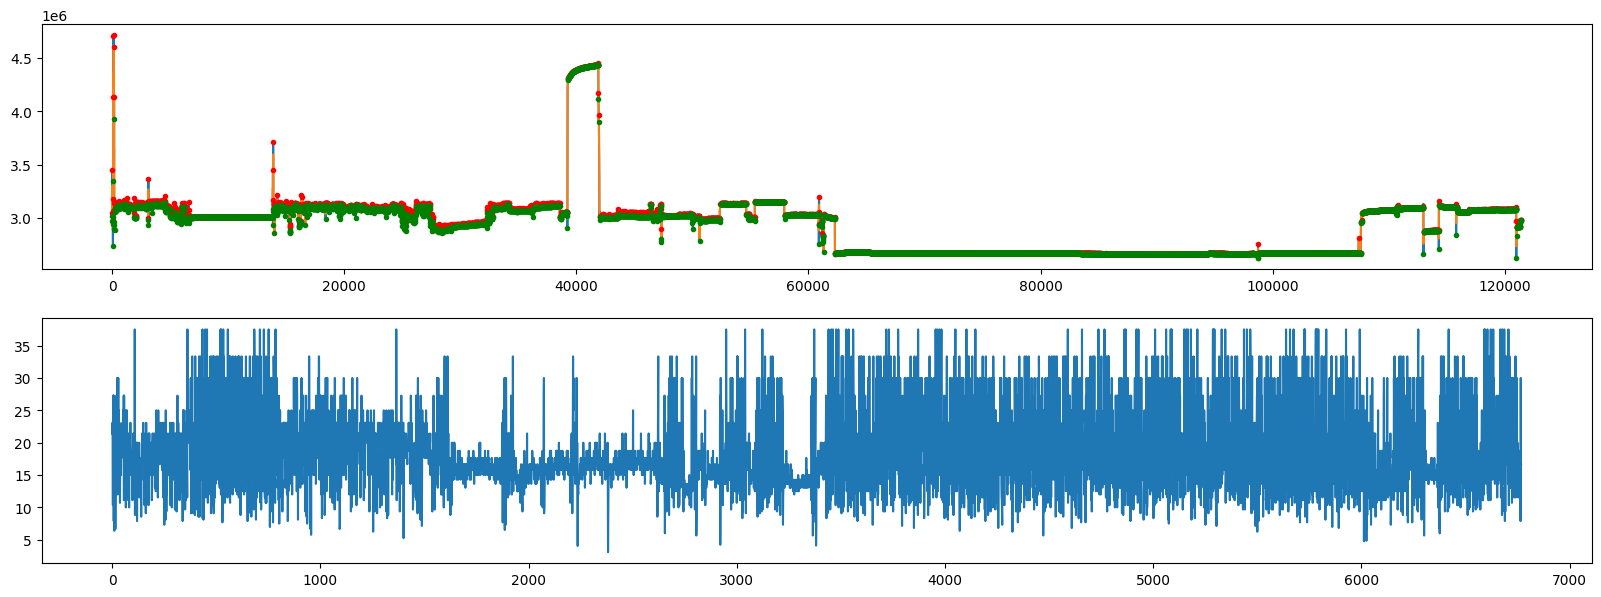

In [19]:
# find_peaks_and_valleys 함수를 사용하여 peak과 bottom 찾기
window_size = 10  # 이동 평균 윈도우 크기
peaks, valleys, moving_avg = find_peaks_and_valleys_2(capf, window_size)
rr = calculate_rr(peaks, time)  # calculate_rr 함수를 사용하여 분당 호흡 수 계산
rr[rr>40] = 40; rrv = abs(np.diff(rr)); rrv = np.append(rrv, np.mean(rrv));
figure(figsize=(20,7)); subplot(211); plot(capf); plot(moving_avg); plot(peaks, capf[peaks], 'r.'); plot(valleys, capf[valleys], 'g.');
subplot(212); plot(rr); 

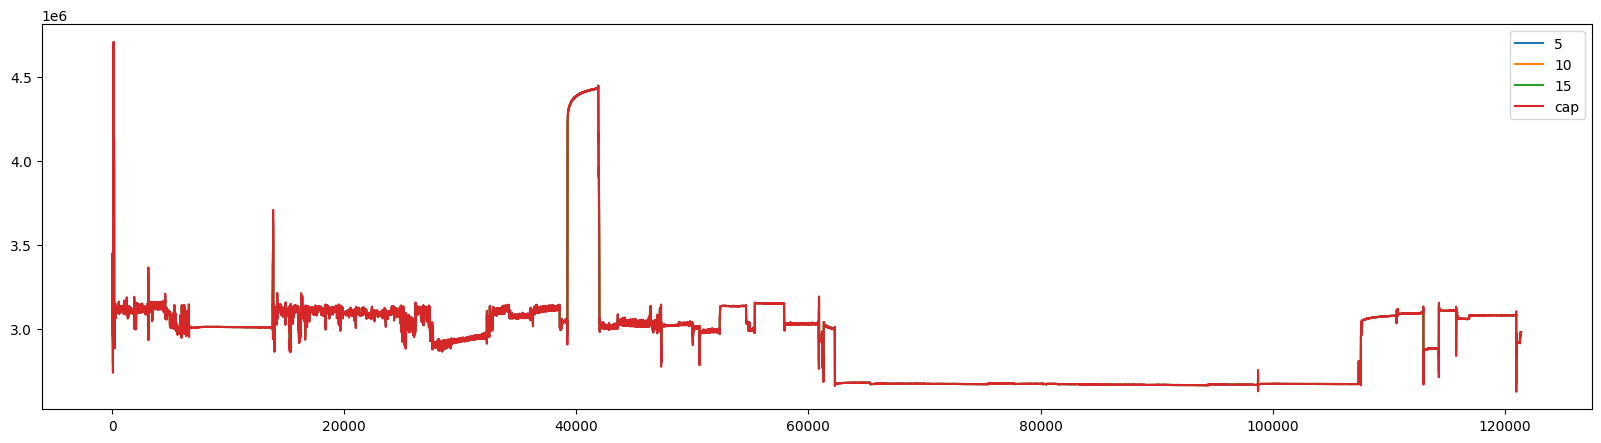

In [20]:
moving_avg_5 = np.convolve(capf, np.ones(5) / 5, mode='valid')
moving_avg_10 = np.convolve(capf, np.ones(10) / 10, mode='valid')
moving_avg_15 = np.convolve(capf, np.ones(15) / 15, mode='valid')
figure(figsize=(20,5)); plot(moving_avg_5, label='5'); plot(moving_avg_10, label='10'); plot(moving_avg_15, label='15'); plot(capf, label='cap'); legend()